# 1. Organization & Purpose

This document aims to provide the reader with a detailed description of my implementation of an NLP sentiment classifier project. The underlying objective of this assignment is to build a text classification model that would predict a label value for word sentences (aka comments) given in the csv file "id_label.csv". Specifically, I am required to build a model that would predict the label values of comments 4000 through 5571.

I am provided with the following pieces of information:  
1. The data file "corpus.txt" providing the corpus of comments and their words to be used in this assignment
2. The data file "id_label.csv" providing the list of comments and their corresponding label values (which are binary in this case, taking either the value zero or one). Comments 0 through 3999 are labelled (i.e., have a label value), comments 4000 through 5571 are not and need to be estimated

The rest of this document is organized as follows in the order given below:
1. Executive summary: Used for providing the gist of the analysis and results obtained giving the reader a sense of the fruits of the work and journey taken to arrive at the results
2. High level approach: Used for providing the reader with the overall strategy I took in order to arrive at the final results. A benefit of having such a strategy in mind is its possible generalizations to tasks beyond this project
3. Implementation: The heart of the project. This section contains the following subsections:    
..a. Assumptions & objective setting: This section provides the main assumptions I make from the information given as well as in the approach that will be taken. This section formalizes the assignment requirement into a mathematical problem. This includes the key performance indicators (KPIs) that will be used in selecting the best model to make the final predictions  
..b. Data management module: This section provides the process of reading and parsing the data, as well as the logic used in handling any existing anomalies (e.g., missing data, erroneous data)  
..c. Modelling module: This section provides the details of the models used, including model performance, the final model I recommend to be used based on certain criteria. All predictions are exported into csv files starting with the term "labels_predict" and then a short-hand name of the model followed by ".csv".
4. Future improvements: This section provides some ideas on how the approach detailed in this document can be improved and generalized given more information and resources
5. Appendix: Acknowledgements & key references: This section provides acknowledgements to key individuals who helped me in certain aspects of this project, as well as references that made implementing this project possible

Finally, I would like to point out that the style of this document is meant to be modular across sections and sub-sections, and linear within these sections and sub-sections as to guide the reader on the thought process of implementing this project.

# 2. Executive Summary

The problem presented is identified as a binary classification problem with features represented as arrays of strings. When parsing the data given, I used a "latin1" type of encoding as the default "utf-8" did not work. This is due to the presence of non-ASCII characters in the corpus dataset. After reading in the data set, I identified two comments missing from the corpus: "3372" and "4822". Because the first comment, "3372" is labelled, I decided to ignore using it in model development. As for the second comment "4822", since I do not have any information on what words contain it, I decided to use a Bayesian base-rate approach: use a random number generator with probability of success equal to the proportion of "1" labels divided by all labelled comments used in training, validation, and testing.

A key assumption I made when analyzing the labelled dataset is that the label value that is less common ("1" in this case) is the one of greater interest. Thus, I chose to use the f1 score as the key metric I am trying to maximize. Accuracy is used as a minimum requirement for filtering out models by comparing accuracy against the accuracy of a baseline stragegy: setting all values of the test dataset with the more common label ("0" in this case) and calculating accuracy (this was about 86% across the samples I used, which means prediction accuracy using the same smaple must surpass this amount).

For modelling, the labelled dataset (excluding those that do not have words in the corpus dataset, which is comment "3372" in this case) is randomly split into three parts: training (for training model parameters), validation (for training model hyperparameters that maximize the f1 score, while meeting minimum accuracy requirements; for models that do not require hyperparameter calibration, this dataset is simply merged with the training dataset), and a testing dataset (which will be used in assessing model performance of each model used). I adoped an iterative approach, starting from simple (e.g., word order not important and independent of other words), quick-to-implement models, to complex (e.g., word read sequentially) models. The following list provides the details of the models I used and the results I obtained:
1. Models that use feature representation represented by word count:  
..a. Naive Bayes: Accuracy=98.8%, f1=95.3% on the testing dataset  
..b. Linear regression with elastic net regularization: Accuracy=98.8%, f1=95.15% on the testing dataset
2. Models that take in words sequentially:
..a. Standard L-layered neural network: Accuracy=91.6%, f1=68.4% (varies a by about 5% per attempt) on testing dataset
..b. Recurrent neural network (RNN): Accuracy=99.3%, f1=97.1% on testing dataset
A similarity comparison was made between the top three models (RNN, Naive Bayes, and elastic net) on the predictions of the unlabelled comments showing very consistent predictions (all three models are about within a two percent difference from each other). 

Thus, given this iteration of model exploration, I would opt to choose the Naive Bayes results if simplicity and large scalability is the focus (assuming the accuracy comparison still holds if we use larger dataset). However, if computational power nor scalability are an issue, then we simply pick the most accurate model.

Potential future improvements on this project could be the following items:
1. Conducting further parameter and hyperparameter searches on the model (depending on resources available). This includes improving the hyperparameter optimization process (e.g., via more iterations especially if computational power is available, via a more effective method than randomization such as gradient ascent and coarse-to-fine methods)
2. Exploring a larger range of models to determine if any would be predictive (e.g., support vector machines, decision trees, ensemble models such as a random forest)
3. Streamlining the decision rules given here for generalization and scalability (e.g., automating the whole process from start to finish, adding a suite of models to provide more options for different datasets)

# 3. High Level Approach

On a high level, I proceed in the following manner:
1. Check all the files given to me by opening them and reviewing them by the naked eye
2. Identify the desirable format of each datum provided in the files should be
3. Create dataframes in the software tool (Python in this case) used. This includes successfully importing the files and reformating the data to the appropriate formats.
4. Identify comprehensive set of scenarios in which data may have quality issues
5. Develop decision logic on how to handle missingness and errors
6. Check for missingness and errors and implement decision logic in previous step on any missing values
7. Set key assumptions and identify KPIs for assessing model performance and conducting model selection
8. Identify the universe of model frameworks to consider and the order in which to approach them
9. Identify training, validation, testing, and prediction datasets. This includes determining the validation approach (if one should is tobe used) and identifying the split ratios
10. Develop models, identify parameter and hyper parameter tuning criteria (this involves trial and error; I provide the end results only here) and assess performance of each model
11. Select winner model(s) and generate predictions for prediction dataset

# 4. Implementation

## 4.1 Assumptions & Objective Setting

I make the following assumptions:
1. Any omissions of comments from the corpus is independent of its label value (i.e., a missing comment from the corpus provides us with no additional insight on its likelihood being labelled zero or one)
2. Blanks are considered as missing words (however, if a word is equal to a space " " or several spaces, we will read it as a word)
3. Case differences between the coded words may imply they are different words (e.g., "Aa" and "aa" may be different and hence I will not treat them as the same)
4. The label value less commonly found in the dataset is of more interest than the common one. If both values are equally common, then I will randomly pick one
5. The labelling of the comments we wish to predict is based on the same criteria used in labelling the labelled comments (i.e., labelled dataset has the same probability distribution as the unlabelled dataset)
6. The order number given (second column of the "corpus.txt" file) represents the position of the word in a comment and thus the highest order number represents the last word of the comment. If an order number is less than one or not a number, it is mislabelled

Based on the assumption and information given to me, I formalize the problem in to the following components:
1. Data point: Comment
2. Features of a sample data point: Words in a comment presented in the given order (top to bottom in the "corpus.txt" file)
3. Sample: Collection of comments
4. Target variable: Label taking either a value of zero or a value of one

Thus, this is a binary classification problem with an array of words (of possible varying length for each comment) as an input and the label value as an output. Therefore, I need to build a model that can accurately predict labels.

Here, accuracy is defined as the number of data points correctly labeled divided by total number of data points in the prediction data set. However, care should be taken when assessing accuracy because a dataset with imbalanced label value frequencies may lead to a high accuracy percentage if simply opted for a set-everything-to-common-label-value strategy. Example: if "0" appears 95% of the data set, then a model that is 90% accurate may not be considered as impressive if we are interested in accurately predicting the "1" values. Thus, given the assumptions above, we will place the f1 score as the primary KPI we wish to maximize. Mathematically, f1 is the harmonic unweighted average (e.g., please see [wiki definition](https://en.wikipedia.org/wiki/Harmonic_mean)) of precision (precision = # true positives / (# true positives + # false positives), where positive reflects the rarer label value) and recall (recall = # true positives / (# true positives + # false negatives), where positive reflects the rarer label value).

In the journey of finding the best model to predict, I set the following criteria:
1. Begin with default or standard parameter and hyper parameter assumption settings given by the software packages used (unless the model is being built from scratch). If performance (as defined in the data set criteria below) is within acceptable tolerance levels, proceed to the next model framework
2. Begin with the simplest model framework and proceed to higher complexity
3. Testing data set:  
..a. Choose only models that have accuracy > set-everything-to-common-label-value strategy accuracy  
..b. Choose a simple model over a more complex one if |f1_complex - f1_simple| <= 2% I am assuming that smaller differences are due to sample volatility. This does not become an issue as the sample size becomes very large (e.g., ten fold the current size) 
4. Training data set:   
..a. accuracy > set-everything-to-common-label-value strategy accuracy  
..b. f1 > 60%  
5. Validation data set (if there is one):  
..a. accuracy > set-everything-to-common-label-value strategy accuracy  
..b. Choose the hyper parameters that maximize f1  
..c. No need to recalibrate hyper parameters if f1 > 90%  
..d. Time to run iterations <= 10 minutes or # iterations >= 100 --> Relax this requirement if no model emerges meeting earlier requirements

## 4.2 Data Management Module

### 4.2.1 Creating Dataframes for "corpus.txt" File & "id_label.csv" Files

In [1]:
#Libraries needed
from copy import deepcopy
import numpy as np
import pandas as pd

In [2]:
corpus_path = "C://Users//bksin//Desktop//NLP//corpus.txt" #Where I stored the files in my computer
labels_path = "C://Users//bksin//Desktop//NLP//id_label.csv" #Where I stored the files in my computer

In [3]:
#Reading corpus file
corpus_df = pd.read_csv(corpus_path, sep=",", header=None, encoding="latin1")
#A "UnicodeDecodeError" error is raised if I try opening the file using this line of code:
#pd.read_csv(corpus_path, sep=",", header=None), which uses the standard "utf-8" format. Using "latin1" words
#as it is able to read in special characters
#Conducted a sanity check to make sure words with non-ascii characters such as the one in comment=5010, order=6, 
#e.g., checking corpus_df[corpus_df["comment"] == 5010, were preserved)

corpus_df.columns = ["comment", "order", "word"]#Label naming

#Taking a look at a sample of the corpus file
corpus_df[0:5]

,comment,order,word
0,0,1,hp
1,0,2,voujm
2,0,3,kvspoh
3,0,4,qpjou
4,0,5,dsbaz


In [4]:
#Reading labels file
labels_df = pd.read_csv(labels_path, header=None)#No problems found here

labels_df.columns = ["comment", "label"]

labels_df_labelled = labels_df[labels_df["label"].notnull()] #Labelled sample
labels_df_unlabelled = labels_df[labels_df["label"].isnull()] #Unlabelled (i.e., prediction) sample

#Taking a look at a sample of the labels file
labels_df[0:5]

,comment,label
0,0,0.0
1,1,0.0
2,2,1.0
3,3,0.0
4,4,0.0


### 4.2.2 Handling Erroneous & Missing Data

#### 4.2.2.1 List of Scenarios

The following list provides all the scenarios I accounted for when parsing the corpus, labelled label, and unlabelled label dataframes:
1. If corpus dataframe has blank comments
2. If corpus dataframe has blank words (i.e., word == "")
3. If corpus dataframe has order values that are not numerical, blank, or not in the correct range (i.e., <1)
4. If corpus dataframe has comments with orders that are sequences that do not increment by one (e.g., {1, 2, 5, 6})
5. If corpus dataframe has duplicated orders for the same comment
6. If labelled label dataframe has comments with a label value that is a number that is not zero or one
7. If labelled label or unlabelled label dataframe has missing comments: Remove rows with blank comments 
8. If labelled label or unlabelled label dataframe has duplicated comments
9. If format of comment in corpus is different from format of comment labelled label and unlabelled label dataframes
10. If label dataframe has any additional comments over corpus dataframe

#### 4.2.2.2 Implementation of Scenarios

##### 4.2.2.2.1 Helper Functions

In [5]:
def remove_blanks(df, column_name, data_type):
    """
        Objective:
        Filter out row blank values of a given column
        
        Arguments:
        df -- Pandas dataframe
        column_name -- Column name of interest we wish to filter out the blanks
        desired_data_type -- Data type of column
        
        Return:
        df_filtered -- Filtered dataframe with given column represented numerically if possible
    """
    df_filtered = deepcopy(df)
    try:
        if data_type == "str":
            df_filtered = df_filtered[df_filtered[column_name] != ""] #Treat the column as a string
        else:
             df_filtered = df[df_filtered[column_name].notnull()] #Treat the column as a numeric
            
    except:
        pass
        
    return df_filtered

#Unit tests
d_str1 = {"A": pd.Series(["1", "2", "3"]), "B": pd.Series([4, 5, 6])}
d_str1_df = pd.DataFrame(data=d_str1)

d_str2 = {"A": pd.Series(["", "2", "3"]), "B": pd.Series([4, 5, 6])}
d_str2_df = pd.DataFrame(data=d_str2)

d_num1 = {"A": pd.Series([1, 2, 3]), "B": pd.Series([4, 5, 6])}
d_num1_df = pd.DataFrame(data=d_num1)

d_num2 = {"A": pd.Series([np.nan, 2, 3]), "B": pd.Series([4, 5, 6])}
d_num2_df = pd.DataFrame(data=d_num2)


column_name = "A"
dt_str1 = "str"
dt_str2 = "str"
dt_num1 = "int"
dt_num2 = "float"

unit_test1 = remove_blanks(d_str1_df, column_name, dt_str1)[column_name].tolist() == ["1", "2", "3"]
unit_test2 = remove_blanks(d_str2_df, column_name, dt_str2)[column_name].tolist() == ["2", "3"]
unit_test3 = remove_blanks(d_num1_df, column_name, dt_num1)[column_name].tolist() == [1, 2, 3]
unit_test4 = remove_blanks(d_num2_df, column_name, dt_num2)[column_name].tolist() == [2.0, 3.0]
unit_test = unit_test1 and unit_test2 and unit_test3 and unit_test4
print("Unit test pass = ", unit_test)

Unit test pass =  True


In [6]:
def find_duplicates(item_list):
    """
        Objective:
        Identify duplicates from a particular list
        
        Arguments:
        item_list -- List of items we wish to find duplicates in (can be any type of list)
        
        Return:
        duplicates_list -- List of duplicated values
    """
    df_duplicates = []
    try:
        for item in item_list:
            if item_list.count(item) > 1 and item not in df_duplicates:
                df_duplicates.append(item)
    except:
        pass
    
    return df_duplicates

#Unit tests
d_list = [1, 1, 2, 2, 2, 3]
unit_test = (find_duplicates(d_list) == [1, 2])
print("Unit test pass = ", unit_test)

Unit test pass =  True


In [7]:
def remove_duplicates(df, column_names, keep):
    """
        Objective:
        Deduplicate redundant rows for given columns
        
        Arguments:
        df -- Pandas dataframe
        column_name -- Column names of interest we wish to deduplicate
        
        Return:
        df_deduplicated -- Deduplicated dataframe with given columns
    """
    try:
        df_deduplicated = deepcopy(df)
        df_deduplicated = df_deduplicated.drop_duplicates(column_names, keep=keep)
    except:
        pass
        
    return df_deduplicated

#Unit tests
d = {"A": pd.Series([1, 1, 2]), "B": pd.Series([4, 5, 6])}
d_df = pd.DataFrame(data=d)

column_names = ["A"]
keep1 = "first"
keep2 = False

unit_test1 = remove_duplicates(d_df, column_names, keep1)["B"].tolist() == [4, 6]
unit_test2 = remove_duplicates(d_df, column_names, keep2)["B"].tolist() == [6]
unit_test = unit_test1 and unit_test2
print("Unit test pass = ", unit_test)

Unit test pass =  True


In [8]:
def consistent_list(item_list):
    """
        Objective:
        Check if all items in a list are equal
        
        Arguments:
        item_list -- List of items (can be of any type)
        
        Return:
        same_items -- Boolean variable indicating whether or not all items in the list are equal to each other
    """
    same_items = True
    try:
        item0 = item_list[0]
        for item in item_list:
            if item0 != item:
                same_items = False
                break
    except:
        pass
    return same_items

#Unit tests
item_list_str1 = ["a", "a", "a"]
item_list_str2 = ["a", "b", "a"]
item_list_num1 = [1, 1, 1]
item_list_num2 = [1, 2, 1]

unit_test1 = (consistent_list(item_list_str1) == True)
unit_test2 = (consistent_list(item_list_str2) == False)
unit_test3 = (consistent_list(item_list_num1) == True)
unit_test4 = (consistent_list(item_list_num2) == False)
unit_test = unit_test1 and unit_test2 and unit_test3 and unit_test4
print("Unit test pass = ", unit_test)

Unit test pass =  True


##### 4.2.2.2.2 Corpus Dataframe Parsing

In [9]:
#1. If corpus dataframe has blank comments: Remove rows with blank comments 
column_name = "comment"
data_type = corpus_df.comment.dtype
corpus_df = remove_blanks(corpus_df, column_name, data_type)

In [10]:
#2. If corpus dataframe has blank words (i.e., word == ""): Leave as is. They will be used in modelling

In [11]:
#3. If corpus dataframe has order values that are not numerical, blank, or not in the correct range (i.e., <1):
#   Coerce orders to be numerical Remove rows with blank orders or not in the correct range
column_name = "order"
data_type = corpus_df.order.dtype

temp = deepcopy(corpus_df) #This deepcopy is used to avoid a chained indexing warning in the next step
temp["order"] = pd.to_numeric(temp["order"], errors="coerce")
temp = remove_blanks(temp, column_name, data_type)#Removing any NA's captured created by the pd.to_numeric function

temp["order"] = temp["order"].astype(int) #Converting the numeric type into integers

temp = temp[temp["order"] >= 1]
temp = temp.sort_values(by=["comment", "order"])#Now that order is an integer, we can sort it
corpus_df = temp

In [12]:
#4. If corpus dataframe has comments with orders that are sequences that do not increment by one (e.g., {1, 2, 5, 6})
#Addressing missing in-between order values will be a criterion to consider in modelling assumptions

In [13]:
#5. If corpus dataframe has duplicated orders for the same comment:
##a. If words are the same, deduplicate and keep 1
##b. If there are different words, deduplicate and keep 1 and replace word with a blank

#Addressing condition a. by deduplicated repeated words
list_of_comments_corpus = set(corpus_df["comment"].unique())


column_names = ["comment", "order", "word"]
keep = "first"
corpus_df = remove_duplicates(corpus_df, column_names, keep)#Deduplicate at word level

#Addressing condition b.
for comment in list_of_comments_corpus:
    list_of_orders = corpus_df[corpus_df["comment"] == comment]["order"].tolist()
    duplicate_orders = find_duplicates(list_of_orders)

    for order in duplicate_orders:
        column_names = ["comment", "order"]
        keep = "first"
        corpus_df = remove_duplicates(corpus_df, column_names, keep)#Deduplicate at order level
        
        #Now each order has one word and we wish to replace this word with a blank
        #First we need to find row number of this word
        ind = corpus_df.index[(corpus_df["comment"] == comment) & (corpus_df["order"] == order)].tolist()[0]
        #Now we can set the word to blank
        corpus_df.loc[ind, "word"] = ""

corpus_df = corpus_df.replace(np.nan, "", regex=True) #Replacing all possibly existing NaNs with blanks

##### 4.2.2.2.2 Labelled and unlabelled Label Dataframes Parsing

In [14]:
#6. If labelled label dataframe has comments with a label value that is a number that is not zero or one: 
#   Remove comment from labelled dataset
#First, we convert the labels into numeric values if they are not numeric

temp = deepcopy(labels_df_labelled) #This deepcopy is used to avoid a chained indexing warning in the next step
temp["label"] = pd.to_numeric(temp["label"], errors="coerce")

column_name = "label"
data_type = temp.label.dtype

temp = remove_blanks(temp, column_name, data_type) #Removing any NA's captured created by the pd.to_numeric function
temp["label"] = temp["label"].astype(int) #Converting the numeric type into integers

labels_df_labelled = temp[(temp["label"] == 0) | (temp["label"] == 1)]
labels_df_labelled[0:5] #Check that labels are in integer form

,comment,label
0,0,0
1,1,0
2,2,1
3,3,0
4,4,0


In [15]:
#7. If labelled label or unlabelled label dataframe has missing comments: Remove rows with blank comments 
column_name = "comment"
data_type = labels_df_labelled.comment.dtype
labels_df_labelled = remove_blanks(labels_df_labelled, column_name, data_type)

data_type = labels_df_unlabelled.comment.dtype
labels_df_unlabelled = remove_blanks(labels_df_unlabelled, column_name, data_type)

In [16]:
#8. If labelled label or unlabelled label dataframe has duplicated comments:
##a. If labelled and label values are the same, deduplicate and keep 1
##b. If labelled and there are at least two comments with different label values, remove comment
##c. If unlabelled, deduplicate and keep 1
column_names = ["comment"]

##Addressing labelled label dataframe:
list_of_comments_labels_labelled = set(labels_df_labelled["comment"].unique())

for comment in list_of_comments_labels_labelled:
    list_of_labels = labels_df_labelled[labels_df_labelled["comment"] == comment]["label"].tolist()
    same_labels = consistent_list(list_of_labels) #Check if all labels are the same

    if same_labels: #Deduplicate comments
        keep = "first"
    else: #Remove all comments
        keep = False
    
    labels_df_labelled[labels_df_labelled["comment"] == comment] = remove_duplicates(labels_df_labelled[\
                                                                   labels_df_labelled["comment"] == comment],\
                                                                                     column_names, keep)

#since the above line is a slice, the outcome will be creating NaNs, so they can be remove in the next few lines
column_name = "comment"
data_type = labels_df_labelled.comment.dtype
labels_df_labelled = remove_blanks(labels_df_labelled, column_name, data_type)

##Addressing unlabelled label dataframe:
keep = "first"
labels_df_unlabelled = remove_duplicates(labels_df_unlabelled, column_names, keep)#Deduplicate at comment level

#Note: If a comment is found both in the labelled and unlabelled label dataframes, then we do not need
#to predict this comment's outcome. I simply use the value found in the labelled label dataframe
#This will be incorporated in the modelling module

##### 4.2.2.2.3 Addressing Potential Incompatilibility Issues between Corpus Dataframe and Labelled and Unlabelled Label dataframes

In [17]:
#9. If format of comment in corpus is different from format of comment labelled label and unlabelled label dataframes
#   Force all formats to be strings

corpus_comment_dtype = corpus_df.comment.dtype
labels_labelled_dtype = labels_df_labelled.comment.dtype
labels_unlabelled_dtype = labels_df_labelled.comment.dtype

if (corpus_comment_dtype != labels_labelled_dtype) or (corpus_comment_dtype != labels_unlabelled_dtype):
    corpus_df["comment"] = corpus_df["comment"].astype(str)
    labels_df_labelled["comment"] = labels_df_labelled["comment"].astype(str)
    labels_df_unlabelled["comment"] = labels_df_unlabelled["comment"].astype(str)
    
#Unit tests:
unit_test1 = (corpus_df.comment.dtype == labels_df_labelled.comment.dtype)
unit_test2 = (corpus_df.comment.dtype == labels_df_unlabelled.comment.dtype)
unit_test = unit_test1 and unit_test2
print("Unit test pass = ", unit_test)

Unit test pass =  True


In [18]:
#10. If label dataframe has any additional comments over corpus dataframe:  
#..a. If missing comment is in labelled dataset, remove comment from labelled dataset  
#..b. If missing comment is in unlabelled dataset, label value will be estimated using a random number 
#generator of a Bernoulli random variable with probability of success equal to frequency of the less
#common label divided by sample size of labelled dataset that will be used for model development

list_of_comments_corpus = set(corpus_df["comment"].unique())
list_of_comments_labels_labelled = set(labels_df_labelled["comment"].unique())
list_of_comments_labels_unlabelled = set(labels_df_unlabelled["comment"].unique())

label_extra_comments_labelled = list_of_comments_labels_labelled - list_of_comments_corpus
label_extra_comments_unlabelled = list_of_comments_labels_unlabelled - list_of_comments_corpus

print(label_extra_comments_labelled)##You will see comment "3374" is missing
print(label_extra_comments_unlabelled)##You will see comment "4822" is missing

#These two sets will be used when developing the model making the predictions

{3374}
{4822}


## 4.3 Modelling Module

### 4.3.1 Libraries Needed

In [19]:
#RNN packages
from keras import optimizers
from keras.callbacks import Callback
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
import keras.backend as K

#Elastic net packages
from sklearn.datasets import make_regression
from sklearn.linear_model import ElasticNet

#Layered NN packages
from tensorflow.python.framework import ops
import tensorflow as tf

#Calculation and plotting packages
import math
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt; plt.rcdefaults()

#Timing package
import time

c:\users\bksin\desktop\jbeast_trader\env\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 4.3.1 Preparing Modelling & Prediction Samples

In [20]:
#We have four samples:
#(1) Modelling sample --> All comments that can be trained, validated, and tested
#(2) Prediction sample via deterministic --> All comments whose labels will be calculated by knowing the
#    value. This occurs in the case that the same comment is found in the training dataset
#(3) Prediction sample via model --> All comments whose labels will be predicted via a model
#(4) Prediction sample via random --> All comments whose labels will be predicted via random number generator

comments_for_modelling = list_of_comments_labels_labelled - label_extra_comments_labelled
comments_for_prediction_deterministic = []
comments_for_prediction_model = []
comments_for_prediction_random = []

for comment in list_of_comments_labels_unlabelled:
    if comment in comments_for_modelling:
        comments_for_prediction_deterministic.append(comment)
    elif comment in label_extra_comments_unlabelled:
        comments_for_prediction_random.append(comment)
    else:
        comments_for_prediction_model.append(comment)

comments_for_prediction_deterministic = set(comments_for_prediction_deterministic) 
comments_for_prediction_model = set(comments_for_prediction_model)
comment_for_prediction_random = set(comments_for_prediction_random)

### 4.3.2 Conducting Preliminary Analytics on Modelling Sample

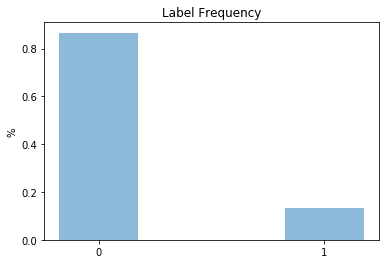

Sample size of modelling sample is  3999
Target label we will use is  1
Number of unique words  8713


In [21]:
list_of_words_master = sorted(corpus_df.word.unique().tolist()) #List of all words in corpus
m = len(comments_for_modelling)
n = len(list_of_words_master)

m_1 = 0
comment_length_list_1_10 = 0
comment_length_list_11_20 = 0
comment_length_list_21_30 = 0
comment_length_list_31_40 = 0
comment_length_list_41_50 = 0
comment_length_list_51_max = 0

for comment in comments_for_modelling:#Counting all of the ones given in comment_for_modelling
    m_1 += labels_df_labelled[labels_df_labelled["comment"] == comment]["label"].tolist()[0]
    comment_length = len(corpus_df[corpus_df["comment"] == comment]["word"].tolist())
    if comment_length <= 10:
        comment_length_list_1_10 += 1
    elif comment_length <= 20:
        comment_length_list_11_20 += 1
    elif comment_length <= 30:
        comment_length_list_21_30 += 1
    elif comment_length <= 40:
        comment_length_list_31_40 += 1
    elif comment_length <= 50:
        comment_length_list_41_50 += 1
    else:
        comment_length_list_51_max += 1
m_0 = m - m_1

x_pos = [0, 1]
labels = ("0", "1")
label_freq = [m_0/m * 1.0, m_1/m * 1.0]
 
plt.bar(x_pos, label_freq, 0.35, align='center', alpha=0.5)
plt.xticks(x_pos, labels)
plt.ylabel("%")
plt.title("Label Frequency")

plt.show()

target_label_master = (m_1 < m_0) * 1

print("Sample size of modelling sample is ", m)
print("Target label we will use is ", target_label_master)
print("Number of unique words ", n)

#As the graph shows below, the label 1 is much less than label zero

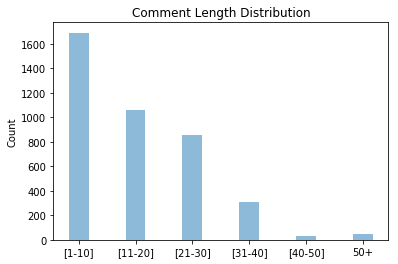

In [22]:
#Looking at comment length distribution. This can give guidance on setting up model variables and explain certain
#results (e.g., adding padding may yield poor results as the majority of comments are ten or less)
x_pos = [0, 1, 2, 3, 4, 5]
labels = ("[1-10]", "[11-20]", "[21-30]", "[31-40]", "[40-50]", "50+")
label_freq = [comment_length_list_1_10, comment_length_list_11_20, comment_length_list_21_30,\
              comment_length_list_31_40,comment_length_list_41_50, comment_length_list_51_max]
 
plt.bar(x_pos, label_freq, 0.35, align='center', alpha=0.5)
plt.xticks(x_pos, labels)
plt.ylabel("Comment length bins")
plt.ylabel("Count")
plt.title("Comment Length Distribution")

plt.show()

### 4.3.1 Splitting the Labelled Label Dataset into Training, Validation, & Testing

In [23]:
#Given that the sample size is quite large, 3999, I will begin our analysis with a simple standard split of
#80%(train), 10%(validate), and 10%(test) . Should I consistently see significant differences between the 
#validation and testing data sets, I may revisit the sampling method (e.g., use k-cross validation, increasing
#number of iterations and combinations of hyper-parameters considered). For now, I am optiming for the simpler 
#option and then will iterate if necessary.
#For cases where a validation dataset is not needed, the training and validation samples are combined. Thus, all
#models evaluated on the same testing dataset

#Obtaining the entire vocabulary of list of words
np.random.seed(0)#Setting a random seed
split_train = 0.8
split_validate = 0.1

comments_for_modelling_training = []
comments_for_modelling_validation = []
comments_for_modelling_testing = []

for comment in comments_for_modelling:
    split_rand = np.random.rand()
    if split_rand <= split_train:
        comments_for_modelling_training.append(comment)
    elif split_rand <= split_train + split_validate:
        comments_for_modelling_validation.append(comment)
    else:
        comments_for_modelling_testing.append(comment)

comments_for_modelling_training = set(comments_for_modelling_training)
comments_for_modelling_validation = set(comments_for_modelling_validation)
comments_for_modelling_testing = set(comments_for_modelling_testing)

### 4.3.2 Building & Testing Models

#### 4.3.2.1 Model Exploration Plan

Model frameworks that could be used for this problem are Naive Bayes, Linear (or logistic) regression with elastic net regularization, support vector machines (SVMs), decision trees, ensemble models (e.g., random forests), standard multi-layered fully connect neural networks (L-layered NN), and recurrent neural networks (RNNs). The strategy is to begin with simple model frameworks and proceed to complex model frameworks without necessarily covering every model type unless models used so far are not performing well.

I divide the frameworks I explore into two types:
1. Models that use feature representation represented by word count --> Order of words is not important, just the frequency
2. Models that index the words --> Words are read in sequence

I begin by tackling the first type, which is based on simpler assumptions. First, I use the Naive Bayes model framework, and then a linear regression with elastic net regularization. I will explore models in the second type (L-layered NNs and RNNs). If none of the model frameworks meet predictive specifications, then I will explore other types of model frameworks and potentially iterate on more hyperparameters.

Note: In the first iteration of model exploration, from simple to complex, missing order values that may be present in the corpus dataframe are ignored, in the sense that all words are taken to be as consecutive. Example: {1: "Thor", 3: "Fantastic"} is read as ["Thor", "Fantastic"] without introducing a filler missing value (e.g., ["Thor", "*", "Fantastic"]). This assumption can be relaxed (assuming that there are missing order values in the corpus dataframe, which is actually the case in this project, but may not be in future datasets) in subsequent iterations of this project, if none of the model frameworks meet predictive specifications.

#### 4.3.2.2 Global Helper Functions

In [24]:
def get_feature_matrix(X, Y, list_of_words):
    """
        Objective:
        Provide a feature matrix that represents word counts for each comment and the label for each comment
    
        Arguments:
        X -- List of comments of shape length=sample size, where each comment is a list of words
        Y -- List of labels, where each label value is either equal to zero or one, of length=sample size
        list_of_words -- List of all words available in the corpus
    
        Returns:
        feature_matrix -- Numpy array of shape = (sample size, number of words + 1)
    """
    m = len(X)
    n = len(list_of_words)
    feature_matrix = np.zeros((m, n+1))
    
    for i in range(m):
        for j in range(n+1):
            if j < n:
                feature_matrix[i, j] = X[i].count(list_of_words[j])
            else:
                feature_matrix[i, j] = Y[i]
   
    return feature_matrix

#Unit tests:
X = [["Thor", "is", "awesome"], ["Sky", "is", "green"]]
Y = [1, 0]
list_of_words = ["awesome", "is", "green", "Sky", "Thor"]

fm_hat = get_feature_matrix(X, Y, list_of_words)
fm_true = np.array([[1, 1, 0, 0, 1, 1], [0, 1, 1, 1, 0, 0]])

unit_test = True
 
for i in range(2):
    for j in range(6):
        unit_testi = (fm_true[i,j] == fm_hat[i,j])
        unit_test = unit_test and unit_testi

print("Unit test pass = ", unit_test)

Unit test pass =  True


In [25]:
def assess_model(Y, Y_hat, target_label, print_performance):
    """
        Objective:
        Provide kpi's of model
    
        Arguments:
        Y -- List of true labels, where each label value is either equal to zero or one, of length=sample size
        Y_hat -- List of predicted labels, where each label value is either equal to zero or one, of length=sample size
        target_label -- Binary integer, either zero or one, indicating which Y variable is the target label
        print_performance -- Boolean variable that is used to determine whether or not to print kpis
    
        Returns:
        accuracy -- A percentage that is equal to (true positive+true negative) / sample size
        precision -- A percentage that is equal to true positive / (true positive + false positive)
        recall -- A percentage that is equal to true positive / (true positive + false negative)
        f1 -- A percentage that is the f1 score and is equal to 2/ (1/precision + 1/recall).
              In other words, it is the harmonic average of precision and recall
    """
    
    epsilon = 1e-10
    m = len(Y)
    
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    for i in range(m):
        if Y[i] == target_label and Y_hat[i] == target_label:#True positive casse
            tp += 1
        elif Y[i] != target_label and Y_hat[i] == target_label:#False positive case
            fp += 1
        elif Y[i] == target_label and Y_hat[i] != target_label:#False negative case
            fn += 1
        elif Y[i] != target_label and Y_hat[i] != target_label:#True negative case
            tn += 1

    accuracy = (tp + tn) / m
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)

    f1 = 2 / (1/ (precision + epsilon) + 1/(recall + epsilon))
    
    if print_performance:
        print("# true positives = ", tp)
        print("# true negatives = ", tn)
        print("# false positives = ", fp)
        print("# false negatives = ", fn)
        
        print("Baseline strategy {:.2%}".format((tn+fp)/m))#All negatives/sample size
        print("accuracy = {:.2%}".format(accuracy))
        print("precision = {:.2%}".format(precision))
        print("recall = {:.2%}".format(recall))
        print("f1 = {:.2%}".format(f1))
        
    return accuracy, precision, recall, f1

#Unit tests:
Y = [1, 1, 0, 0, 0, 0]
Y_hat = [1, 0, 1, 1, 0, 0]
target_label = 1
print_performance = False
accuracy, precision, recall, f1 = assess_model(Y, Y_hat, target_label, print_performance)

epsilon = 1e-10
unit_test1 = (accuracy == (1 + 2) / 6)
unit_test2 = (precision == 1 / (1 + 2 + epsilon))
unit_test3 = (recall == 1 / (1 + 1 + epsilon))
unit_test4 = (f1 == 2 / (1/(precision + epsilon) + 1/(recall + epsilon))) 
unit_test = unit_test1 and unit_test2 and unit_test3 and unit_test4
print("Unit test pass = ", unit_test)

Unit test pass =  True


#### 4.3.2.3 Model Framework 1: Naive Bayes

##### 4.3.2.3.1 Assumptions & Set-up

This model framework is based on the following two key assumptions:
1. Word order is not important
2. Words given label are conditionally independent of each other

Inputs: I use word count as the feature input vector for each comment
Output: Probability of each label value occurring. The label value chosen is the the one that has the higher probability of occurring

Note: A validation sample is not required for this model as there are no hyper parameters to calibrate

##### 4.3.2.3.2 Local Helper Functions

In [26]:
def get_prob_word_given_label(feature_matrix, target_label):
    """
        Objective:
        Calculate the probabilities of any word occurring given a label value
    
        Arguments:
        feature_matrix -- Numpy array of shape = (sample size, number of words + 1)
        target_label -- Binary integer, either zero or one, indicating which Y variable is the target label
    
        Returns:
        probabilities -- Tuple of values: (prob_word_given_pos_vector, prob_word_given_neg_vector, prob_pos, prob_neg)
                         prob_word_given_pos_vector --> Numpy array of shape (number of words, 1)
                         prob_word_given_neg_vector --> Numpy array of shape (number of words, 1)
                         prob_pos --> Scalar value between zero and one, representing probability of getting target 
                                      label
                         prob_neg --> Scalar value between zero and one, representing probability of getting 
                                      non-target label
    """
    m, n = feature_matrix.shape
    n = n - 1
    
    prob_word_given_pos_vector = np.zeros((n, 1))
    prob_word_given_neg_vector = np.zeros((n, 1))
    epsilon = 1e-10 #Used for avoiding a division by zero scenario
    
    for j in range(n):
        count_pos = 0
        count_neg = 0
        for i in range(m):
            if feature_matrix[i, n] == target_label:
                count_pos += feature_matrix[i, j]
            else:
                count_neg += feature_matrix[i, j]

        prob_word_given_pos_vector[j] = count_pos
        prob_word_given_neg_vector[j] = count_neg

    prob_word_given_pos_vector /= (np.sum(prob_word_given_pos_vector) + epsilon)
    prob_word_given_neg_vector /= (np.sum(prob_word_given_neg_vector) + epsilon)

    prob_pos = np.sum(feature_matrix[:, n]) / m
    prob_neg = 1 - prob_pos
    
    probabilities = (prob_word_given_pos_vector, prob_word_given_neg_vector, prob_pos, prob_neg)
    return probabilities

#Unit tests:
epsilon = 1e-10
feature_matrix = np.array([[1,2,1],[1,2,0],[0,1,0]])
target_label = 1

probabilities = get_prob_word_given_label(feature_matrix, target_label)
(prob_word_given_pos_vector, prob_word_given_neg_vector, prob_pos, prob_neg) = probabilities

unit_test1 = (prob_word_given_pos_vector[0] == 1 / (3 + epsilon))[0]
unit_test2 = (prob_word_given_pos_vector[1] == 2 / (3 + epsilon))[0]
unit_test3 = (prob_word_given_neg_vector[0] == 1 / (4 + epsilon))[0]
unit_test4 = (prob_word_given_neg_vector[1] == 3 / (4 + epsilon))[0]
unit_test3 = (prob_word_given_neg_vector[0] == 1 / (4 + epsilon))[0]
unit_test5 = (prob_pos == 1./3)
unit_test6 = (prob_neg == 1 - prob_pos)
unit_test = unit_test1 and unit_test2 and unit_test3 and unit_test4 and unit_test5 and unit_test6
print("Unit test pass = ", unit_test)

Unit test pass =  True


In [27]:
def predict_Y_naive_bayes(X, list_of_words, probabilities):
    """
        Objective:
        Estimate labels via the Naive Bayes model framework

        Arguments:
        X -- List of comments of shape length=sample size, where each comment is a list of words
        list_of_words -- List of all words available in the corpus
        probabilities -- Tuple of values: (prob_word_given_pos_vector, prob_word_given_neg_vector, prob_pos, prob_neg)
                         prob_word_given_pos_vector --> Numpy array of shape (number of words, 1)
                         prob_word_given_neg_vector --> Numpy array of shape (number of words, 1)
                         prob_pos --> Scalar value between zero and one, representing probability of getting target 
                         label
                         prob_neg --> Scalar value between zero and one, representing probability of getting 
                                      non-target label

        Returns:
        Y_hat -- List of predicted labels, where each label value is either equal to zero or one, of length=sample size
    """
    
    (prob_word_given_pos_vector, prob_word_given_neg_vector, prob_pos, prob_neg) = probabilities
    m = len(X)
    epsilon = 1e-10 #Used for avoiding a division by zero scenario
    
    Y_hat = []
    for i in range(m):
        comment = X[i]
        yhat_pos = np.log(prob_pos+epsilon)#Using logarithms for numerical stability
        yhat_neg = np.log(prob_neg+epsilon)#Using logarithms for numerical stability

        for word in comment:       
            j = list_of_words.index(word)
            yhat_pos += np.log(prob_word_given_pos_vector[j]+epsilon)
            yhat_neg += np.log(prob_word_given_neg_vector[j]+epsilon)
        
        y_hat_np= (yhat_pos > yhat_neg) * 1#List containing a numpy array
        Y_hat.append(y_hat_np[0])
    
    return Y_hat

#Unit tests:
epsilon = 1e-10
prob_word_given_pos_vector = np.array([[1 / (3 + epsilon)], [2/ (3 + epsilon)]])
prob_word_given_neg_vector = np.array([[3 / (4 + epsilon)], [1/ (4 + epsilon)]])
prob_pos = 2./3
prob_neg = 1 - prob_pos

X = [["Hulk", "good"], ["Hulk"], ["good"]]
list_of_words = ["good", "Hulk"]
probabilities = (prob_word_given_pos_vector, prob_word_given_neg_vector, prob_pos, prob_neg)
Y_hat = predict_Y_naive_bayes(X, list_of_words, probabilities)

unit_test = (Y_hat == [1, 1, 0])
print("Unit test pass = ", unit_test)

Unit test pass =  True


##### 4.3.2.3.2 Model Development

In [28]:
#Compiling training and testing datasets
X_train = []
Y_train = []

X_test = []
Y_test = []

for comment in comments_for_modelling_training.union(comments_for_modelling_validation):
    x = corpus_df[corpus_df["comment"] == comment]["word"].tolist()
    y = labels_df_labelled[labels_df_labelled["comment"] == comment]["label"].tolist()[0]
    X_train.append(x)
    Y_train.append(y)
    
for comment in comments_for_modelling_testing: 
    x = corpus_df[corpus_df["comment"] == comment]["word"].tolist()
    y = labels_df_labelled[labels_df_labelled["comment"] == comment]["label"].tolist()[0]
    X_test.append(x)
    Y_test.append(y)

list_of_words = list_of_words_master
feature_matrix = get_feature_matrix(X_train, Y_train, list_of_words)

In [29]:
#Training the model
target_label = target_label_master

tic = time.clock()
probabilities = get_prob_word_given_label(feature_matrix, target_label)
(prob_word_given_pos_vector, prob_word_given_neg_vector, prob_pos, prob_neg) = probabilities
toc = time.clock()

time_taken = (toc - tic) / 60 
print("Time taken = {:.2f} minutes".format(time_taken))

Time taken = 0.26 minutes


In [30]:
#Assessing performance of training dataset
list_of_words = list_of_words_master
Y_hat_train = predict_Y_naive_bayes(X_train, list_of_words, probabilities)
print_performance = True
accuracy_train, precision_train, recall_train, f1_train = assess_model(Y_train, Y_hat_train, target_label,\
                                                                       print_performance)
#Results below show that the training dataset is a good fit:
#Accuracy > baseline
#f1 is quite high

# true positives =  478
# true negatives =  3082
# false positives =  6
# false negatives =  3
Baseline strategy 86.52%
accuracy = 99.75%
precision = 98.76%
recall = 99.38%
f1 = 99.07%


In [31]:
#Assessing performance of testing dataset
list_of_words = list_of_words_master
Y_hat_test = predict_Y_naive_bayes(X_test, list_of_words, probabilities)
print_performance = True
accuracy_test, precision_test, recall_test, f1_test = assess_model(Y_test, Y_hat_test, target_label,\
                                                                       print_performance)
#Results below show that the testing dataset is a good fit:
#Accuracy > baseline
#f1 is quite high

# true positives =  51
# true negatives =  374
# false positives =  2
# false negatives =  3
Baseline strategy 87.44%
accuracy = 98.84%
precision = 96.23%
recall = 94.44%
f1 = 95.33%


##### 4.3.2.3.3 Predicting Unlabelled Labels

In [32]:
comment_list_predict = []
X_predict = []
Y_hat_predict_naive_bayes = []

for comment in comments_for_prediction_model: 
    x = corpus_df[corpus_df["comment"] == comment]["word"].tolist()
    X_predict.append(x)
    comment_list_predict.append(comment)

list_of_words = list_of_words_master
Y_hat_predict_naive_bayes = predict_Y_naive_bayes(X_predict, list_of_words, probabilities)

for comment in comments_for_prediction_deterministic:
    y_hat = label_df_labelled[corpus_df["comment"] == comment]["label"].tolist()[0]
    comment_list_predict.append(comment)
    Y_hat_predict_naive_bayes.append(y_hat)

target_label = target_label_master
if target_label == 1:
    p = np.sum(Y_train)/len(Y_train)
else:
    p = 1 - np.sum(Y_train)/len(Y_train)

rand_seed_counter = 0
for comment in comments_for_prediction_random:
    np.random.seed(rand_seed_counter)
    if np.random.rand() < p:
        y_hat = target_label
    else:
        y_hat = 1 - target_label
    comment_list_predict.append(comment)
    Y_hat_predict_naive_bayes.append(y_hat)
    rand_seed_counter += 1

In [33]:
predict_candidate_naive_bayes = {"comments": comment_list_predict, "labels": Y_hat_predict_naive_bayes}
predict_candidate_naive_bayes_df = pd.DataFrame(data=predict_candidate_naive_bayes)
predict_candidate_naive_bayes_df = predict_candidate_naive_bayes_df.sort_values(by=["comments"])
predict_candidate_naive_bayes_df  = predict_candidate_naive_bayes_df.reset_index(drop=True)
predict_candidate_naive_bayes_df[0:5]

,comments,labels
0,4000,0
1,4001,0
2,4002,0
3,4003,0
4,4004,0


In [34]:
predict_path = "C://Users//bksin//Desktop//NLP//labels_predict_naive_bayes.csv"#Where I stored the files in my computer
predict_candidate_naive_bayes_df.to_csv(predict_path, index=False)

##### 4.3.2.3.4 Conclusion

The Naive Bayes approach is an excellent fit suggesting that the presence of certain words in a comment is the dominating factor for predicting label value. Furthermore, it poses a great advantage over more complex model frameworks in its similicity and speed, which can be crucial if computational power is expensive.

#### 4.3.2.4 Model Framework 2: Linear Regression with Elastic Net Regularization

##### 4.3.2.4.1 Assumptions & Set-up

This model framework is based on the following two key assumptions:
1. Word order is not important
2. Words given label are conditionally independent of each other

Inputs: I use word count as the feature input vector for each comment  
Output: Probability of each label value occurring. The label value chosen is the the one that has the higher probability of occurring

Note: A validation dataset will be used to find the optimal combination of the following two hyper parameters (I was not able to achieve an f1 > 90% with default parameter values and hence will aim to optimize hyper parameters):
1. alpha --> sum of the L1 and L2 regularization parameters
2. l1_ratio --> L1 regularization term / alpha

##### 4.3.2.4.2 Model Development

In [35]:
#Compiling training, validation, and testing datasets
X_train = []
Y_train = []

X_validate = []
Y_validate = []

X_test = []
Y_test = []

for comment in comments_for_modelling_training:
    x = corpus_df[corpus_df["comment"] == comment]["word"].tolist()
    y = labels_df_labelled[labels_df_labelled["comment"] == comment]["label"].tolist()[0]
    X_train.append(x)
    Y_train.append(y)

for comment in comments_for_modelling_validation: 
    x = corpus_df[corpus_df["comment"] == comment]["word"].tolist()
    y = labels_df_labelled[labels_df_labelled["comment"] == comment]["label"].tolist()[0]
    X_validate.append(x)
    Y_validate.append(y)
    
for comment in comments_for_modelling_testing: 
    x = corpus_df[corpus_df["comment"] == comment]["word"].tolist()
    y = labels_df_labelled[labels_df_labelled["comment"] == comment]["label"].tolist()[0]
    X_test.append(x)
    Y_test.append(y)

list_of_words = list_of_words_master
feature_matrix_train = get_feature_matrix(X_train, Y_train, list_of_words)
feature_matrix_validate = get_feature_matrix(X_validate, Y_validate, list_of_words)
feature_matrix_test = get_feature_matrix(X_test, Y_test, list_of_words)

#Formatting the input and outputs to be used by the sklearn function ElasticNet()
X_train_e = feature_matrix_train[:,:-1]
Y_train_e = feature_matrix_train[:,-1]
X_validate_e = feature_matrix_validate[:,:-1]
Y_validate_e = feature_matrix_validate[:,-1]
X_test_e = feature_matrix_test[:,:-1]
Y_test_e = feature_matrix_test[:,-1]

In [36]:
#Training the model
#Hyper parameter bounds were set by trial and error
target_label = target_label_master

tic_all = time.clock()
print_performance = False
iterations = 100 #Each iteration takes about 1/10 minutes on my laptop (2.6 GH, 16GB RAM)

model_list = []
f1_validate_best = 0

#Calculating base_line_strategy_accuracy
if target_label == 1:
    baseline_strategy_accuracy_train = 1 - np.sum(Y_train_e)/Y_train_e.shape[0]
    baseline_strategy_accuracy_validate = 1 - np.sum(Y_validate_e)/Y_validate_e.shape[0]
    baseline_strategy_accuracy_test = 1 - np.sum(Y_test_e)/Y_test_e.shape[0]

else:
    baseline_strategy_accuracy_train = np.sum(Y_train_e)/Y_train_e.shape[0]
    baseline_strategy_accuracy_validate = np.sum(Y_validate_e)/Y_validate_e.shape[0]
    baseline_strategy_accuracy_test = np.sum(Y_test_e)/Y_test_e.shape[0]

for i in range(iterations):
    tic_one = time.clock()
    
    alpha = 10**(-3*np.random.rand())#Hyper parameter randomization
    l1_ratio = 10**(-3*np.random.rand() - 1)#Hyper parameter randomization
    
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=0)
    
    model.fit(X_train_e, Y_train_e)
    
    model_list.append(model)
        
    Y_hat_train_e = model.predict(X_train_e)
    Y_hat_train_e = (Y_hat_train_e > 0.5) * 1
    
    accuracy_train, precision_train, recall_train, f1_train = assess_model(Y_train_e, Y_hat_train_e, target_label,\
                                                                           print_performance)
    Y_hat_validate_e = model.predict(X_validate_e)
    Y_hat_validate_e = (Y_hat_validate_e > 0.5) * 1
    accuracy_validate, precision_validate, recall_validate, f1_validate = assess_model(Y_validate_e, \
                                                                                       Y_hat_validate_e, target_label,\
                                                                                       print_performance)
    if i == 0:
        f1_validate_best = f1_validate
        best_model = model
    else:
        if accuracy_train > baseline_strategy_accuracy_train and\
        accuracy_validate> baseline_strategy_accuracy_validate and\
        f1_validate > f1_validate_best:
            f1_validate_best = f1_validate
            best_model = model
    
    toc_one = time.clock()       
    time_taken_one = (toc_one - tic_one) / 60
    print("Model {}".format(i+1), ", accuracy_train = {:.2%}".format(accuracy_train).format(l1_ratio),\
          ", accuracy_validate = {:.2%}".format(accuracy_validate), ", f1_validate = {:.2%}".format(f1_validate),\
          ", Time taken = {:.2f} minutes".format(time_taken_one))
    
toc_all = time.clock()
time_taken_all = (toc_all - tic_all) / 60 
print("Time taken = {:.2f} minutes".format(time_taken_all))

Model 1 , accuracy_train = 99.06% , accuracy_validate = 98.20% , f1_validate = 92.13% , Time taken = 0.07 minutes
Model 2 , accuracy_train = 97.77% , accuracy_validate = 96.91% , f1_validate = 86.05% , Time taken = 0.03 minutes
Model 3 , accuracy_train = 98.52% , accuracy_validate = 97.42% , f1_validate = 88.64% , Time taken = 0.05 minutes
Model 4 , accuracy_train = 99.81% , accuracy_validate = 98.45% , f1_validate = 93.18% , Time taken = 0.32 minutes
Model 5 , accuracy_train = 96.64% , accuracy_validate = 96.13% , f1_validate = 81.48% , Time taken = 0.03 minutes
Model 6 , accuracy_train = 97.83% , accuracy_validate = 96.91% , f1_validate = 86.05% , Time taken = 0.03 minutes
Model 7 , accuracy_train = 99.50% , accuracy_validate = 98.45% , f1_validate = 93.18% , Time taken = 0.09 minutes
Model 8 , accuracy_train = 86.36% , accuracy_validate = 87.89% , f1_validate = 0.00% , Time taken = 0.02 minutes
Model 9 , accuracy_train = 99.56% , accuracy_validate = 98.45% , f1_validate = 93.18% , T

Model 73 , accuracy_train = 98.02% , accuracy_validate = 97.16% , f1_validate = 87.36% , Time taken = 0.05 minutes
Model 74 , accuracy_train = 99.81% , accuracy_validate = 98.45% , f1_validate = 93.18% , Time taken = 0.25 minutes
Model 75 , accuracy_train = 99.81% , accuracy_validate = 98.20% , f1_validate = 91.95% , Time taken = 0.13 minutes
Model 76 , accuracy_train = 99.34% , accuracy_validate = 98.45% , f1_validate = 93.18% , Time taken = 0.08 minutes
Model 77 , accuracy_train = 97.27% , accuracy_validate = 96.91% , f1_validate = 86.05% , Time taken = 0.04 minutes
Model 78 , accuracy_train = 99.65% , accuracy_validate = 98.45% , f1_validate = 93.18% , Time taken = 0.19 minutes
Model 79 , accuracy_train = 97.96% , accuracy_validate = 96.91% , f1_validate = 86.05% , Time taken = 0.03 minutes
Model 80 , accuracy_train = 86.99% , accuracy_validate = 87.89% , f1_validate = 0.00% , Time taken = 0.02 minutes
Model 81 , accuracy_train = 97.33% , accuracy_validate = 96.39% , f1_validate = 8

In [37]:
#Assessing performance of testing dataset
target_label = target_label_master
Y_hat_test_e = best_model.predict(X_test_e)
Y_hat_test_e = (Y_hat_test_e > 0.5) * 1

print_performance = True
accuracy_test, precision_test, recall_test, f1_test = assess_model(Y_test_e, Y_hat_test_e, target_label,\
                                                                                   print_performance)
#Results below show that the testing dataset is a good fit:
#Accuracy > baseline
#f1 is quite high

# true positives =  49
# true negatives =  376
# false positives =  0
# false negatives =  5
Baseline strategy 87.44%
accuracy = 98.84%
precision = 100.00%
recall = 90.74%
f1 = 95.15%


##### 4.3.2.4.3 Predicting Unlabelled Labels

In [38]:
target_label = target_label_master
comment_list_predict = []
X_predict = []

for comment in comments_for_prediction_model: 
    x = corpus_df[corpus_df["comment"] == comment]["word"].tolist()
    X_predict.append(x)
    comment_list_predict.append(comment)

list_of_words = list_of_words_master

Y_predict = [0]*len(X_predict)#Just used to run the feature matrix
feature_matrix_predict = get_feature_matrix(X_predict, Y_predict, list_of_words)
X_predict_e = feature_matrix_predict[:,:-1]

Y_hat_predict_e = best_model.predict(X_predict_e)
Y_hat_predict_e = (Y_hat_predict_e > 0.5) * 1
Y_hat_predict_e = Y_hat_predict_e.tolist()

for comment in comments_for_prediction_deterministic:
    y_hat = label_df_labelled[corpus_df["comment"] == comment]["label"].tolist()[0]
    comment_list_predict.append(comment)
    Y_hat_predict_e.append(y_hat)

target_label = target_label_master
if target_label == 1:
    p = np.sum(Y_train)/len(Y_train)
else:
    p = 1 - np.sum(Y_train)/len(Y_train)

rand_seed_counter = 0
for comment in comments_for_prediction_random:
    np.random.seed(rand_seed_counter)
    if np.random.rand() < p:
        y_hat = target_label
    else:
        y_hat = 1 - target_label
    comment_list_predict.append(comment)
    Y_hat_predict_e.append(y_hat)
    rand_seed_counter += 1

In [39]:
predict_candidate_e = {"comments": comment_list_predict, "labels": Y_hat_predict_e}
predict_candidate_e_df = pd.DataFrame(data=predict_candidate_e)
predict_candidate_e_df = predict_candidate_e_df.sort_values(by=["comments"])
predict_candidate_e_df  = predict_candidate_e_df.reset_index(drop=True)
predict_candidate_e_df[0:5]

,comments,labels
0,4000,0
1,4001,0
2,4002,0
3,4003,0
4,4004,0


In [40]:
predict_path = "C://Users//bksin//Desktop//NLP//labels_predict_elastic_net.csv"#Where I stored the files in my computer
predict_candidate_e_df.to_csv(predict_path, index=False)

##### 4.3.2.4.4 Conclusion

The linear regression with elastic net regularization approach is an excellent fit suggesting that the presence of certain words in a comment is the dominating factor for predicting label value.

#### 4.3.2.5 Model Framework 3: L-Layered Neural Network

##### 4.3.2.5.1 Assumptions & Set-up

This model framework is based on the following two key assumptions:
1. Word order is important
2. All comments with number of words shorter than the maximum comment will be padded, so that all comments are of equal length, and such padding will not have a significant impact on predictions
3. Blank values will be given a special character

Inputs: Each word is converted into an index number from 1 until the maximum number of words in the corpus list of words. Padding will have a zero assigned value. All inputs are then standardized by subtracting the training sample mean index value and training sample standard deviation (I use the training sample mean and std for standardizing all datasets)  
Output: Estimate of Y, either zero or one

Note: A validation dataset will be used to find the optimal combination of the following hyper parameters (I was not able to achieve an f1 > 90% with default parameter values and hence will aim to optimize hyper parameters):
1. Layers dimension -- Number of layers and the number of units in each layer
2. Activation function -- Either a Rectified Linear Unit (ReLU) or tanh function for hidden layers. Output layer uses a sigmoid function since the outcome is binary
3. L2 beta -- Hyperparameter that is used to control the effect of L2 regularization
4. keep prob -- Hyperparameter that controls the amount of drop out (a regularization tool)  
5. Starter learning_ ate -- Hyperparameter positive number used to control the starting point of the learning rate
6. ADAM beta1 -- Hyperparameter non-negative number controlling exponential decay component of the ADAM algorithm
7. ADAM_beta2 -- Hyperparameter non-negative number controlling RMSprop component of the ADAM algorithm
8. Decay_rate -- Hyperparameter positive number used to control the rate of decay of the learning rate
9. Number of epochs -- Number of epochs of the optimization loop
10. Minibatch_size -- Sample size of each batch

##### 4.3.2.5.2 Local Helper Functions

In [41]:
#The following helper functions are all used to build the L-layer NN. The majority of the code below is based on
#assignments completed in the Coursera first and second Deep Learning specialization courses. Modifications were
#made here to increase flexibility of tweaking hyper parameters

def create_placeholders(n_x, n_y):
    """
        Objective:
        Creates placeholders for the tensorflow session

        Arguments:
        n_x = integer representing the number of features of X
        n_y = integer representing the number of outputs we want (in this case, n_y = 2)

        Returns:
        X -- Placeholder for the input features, of shape (n_x, None) and dtype "float32"
        Y -- Placeholder for the output variables, of shape (n_y, None) and dtype "float32"
    """
    X = tf.placeholder(tf.float32, shape=(n_x, None))
    Y = tf.placeholder(tf.float32, shape=(n_y, None))
    
    return X, Y

def initialize_parameters(layers_dims):
    """
        Objective:
        Initialize parameters of the neural network

        Arguments:
        layers_dims -- A list of integers that provides the number of units of each layer including the first layer

        Returns:
        parameters -- A dictionary of tensors containing weight and bias variables of all layers
        weights -- A tensor containing weights
    """
    parameters = {}
    
    L = len(layers_dims)
    
    for l in range(1, L):
        nl_prev = layers_dims[l-1]
        nl = layers_dims[l]
        W = tf.get_variable("W" + str(l), [nl, nl_prev], initializer = tf.contrib.layers.xavier_initializer())
        b = tf.get_variable("b" + str(l), [nl, 1], initializer = tf.zeros_initializer())
        
        W_reshape = tf.reshape(W, [1, nl*nl_prev])
        
        if l == 1:
            weights = W_reshape
        else:
            weights = tf.concat([weights, W_reshape], 1)
        
        parameters["W" + str(l)] = W
        parameters["b" + str(l)] = b
    
    return parameters, weights

def forward_propagation(X, parameters, activation_fn, keep_prob):
    """
        Objective:
        Implements the forward propagation component of the model

        Arguments:
        X -- Input data placeholder of shape (number of features, sample size)
        parameters -- A dictionary of tensors containing weight and bias variables of all layers
        activation_fn -- A hyperparameter that is string used to determine the activation function used in the 
                         hidden layers Currently takes on "relu" or "tanh"
        keep_prob -- Hyperparameter that controls the amount of drop out (a regularization tool)

        Returns:
        ZL -- Placeholder of shape (2, number of units in previous layer).
              Represents the linear unit value of the last layer
    """
    
    L = len(parameters) // 2 #The number of layers
    A = X
    for l in range(1, L+1):
        W = parameters["W" + str(l)]
        b = parameters["b" + str(l)]
        
        Z = tf.add(tf.matmul(W, A), b)
        
        if l < L:
            if activation_fn == "relu":
                A = tf.nn.relu(Z) #A = max(0,Z)
            else:#Default
                A = tf.nn.tanh(Z)    
            drop_out = tf.nn.dropout(A, keep_prob)  #Apply drop out
    ZL = Z
    return ZL

def compute_cost(ZL, Y, weights, l2_beta):
    """
        Objective:
        Computes the cost

        Arguments:
        ZL -- Placeholder of shape (1, number of units in previous layer).
              Represents the linear unit value of the last layer
        Y -- Placeholder for the output variables, of shape (n_y, sample_size) and dtype "float32"
        weights -- Numpy array of weights of shape (1, total number of weights)
        l2_beta -- Hyperparameter that takes on non-negative values used to control the effect of L2 regularization

        Returns:
        cost -- Tensor of the cost function
    """
    logits = tf.transpose(ZL)
    labels = tf.transpose(Y)
    w = tf.transpose(weights)
    
    regularizer = tf.nn.l2_loss(w)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels) + \
                          l2_beta*regularizer)
        
    return cost

def random_minibatches(X, Y, minibatch_size):
    """
        Objective:
        Create a list of mini-batches from (X, Y)

        Arguments:
        X -- Input data of shape (number of features, sample size)
        Y -- Output data of shape (number of outputs, sample size)
        minibatch_size -- Sample size of each batch

        Returns:
        minibatches -- List of mini-batches (X_minibatch, Y_minibatch)
    """
    
    m = X.shape[1]
    minibatches = []
    
    #1) Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    
    X_shuffled = X[:, permutation].reshape((X.shape[0], m)) #Handling the case that X has only one feature
    Y_shuffled = Y[:, permutation].reshape((Y.shape[0], m)) #Handling the case that Y is only one output
    
    #2) Partition (shuffled_X, shuffled_Y), excluding last batch in the case that m/minibatch_size is not an integer
    num_complete_minibatches = math.floor(m/minibatch_size)
    
    for k in range(0, num_complete_minibatches):
        X_minibatch = X_shuffled[:, k*minibatch_size: (k+1)*minibatch_size]
        Y_minibatch = Y_shuffled[:, k*minibatch_size: (k+1)*minibatch_size]
        
        minibatch = (X_minibatch, Y_minibatch)
        minibatches.append(minibatch)
    
    #Handling the case that m/minibatch_size is not an integer
    if m % minibatch_size != 0:
        X_minibatch = X_shuffled[:, num_complete_minibatches*minibatch_size: m]
        Y_minibatch = Y_shuffled[:, num_complete_minibatches*minibatch_size: m]
        
        minibatch = (X_minibatch, Y_minibatch)
        minibatches.append(minibatch)
    
    return minibatches


def train_layered_nn(X_train, Y_train, layers_dims,  activation_fn, l2_beta, keep_prob, starter_learning_rate,\
                     adam_beta1, adam_beta2, decay_rate, num_epochs, minibatch_size, print_cost_flag):
    """
        Objective:
        Train the neural network

        Arguments:
        X_train -- Training input data (normalized) of shape (number of features, training sample size)
        Y_train -- Training output data of shape (2, training sample size)
        layers_dims -- A list of integers that provides the number of units of each layer including the first layer
        activation_fn -- A hyperparameter that is string used to determine the activation function used in the 
                         hidden layers Currently takes on "relu" or "tanh"
        l2_beta -- Hyperparameter that takes on non-negative values used to control the effect of L2 regularization
        keep_prob -- Hyperparameter that controls the amount of drop out (a regularization tool)  
        starter_learning_rate -- Hyperparameter positive number used to control the starting point of the learning 
                                 rate
        adam_beta1 -- Hyperparameter non-negative number controlling exponential decay component of the ADAM algorithm
        adam_beta2 -- Hyperparameter non-negative number controlling RMSprop component of the ADAM algorithm
        decay_rate -- Hyperparameter positive number used to control the rate of decay of the learning rate
        num_epochs -- Number of epochs of the optimization loop
        minibatch_size -- Sample size of each batch
        print_cost_flag -- Boolean variable that is used to determine if cost function should be printed and graphed

        Returns:
        parameters -- A dictionary containing final calibrated weight and bias variables of all layers
    """
    #########################################################################################################
    #Modelling component#
    #########################################################################################################
    ops.reset_default_graph() #Used to make it possible to rerun model without overwriting tf variables
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    costs = []
    
    X, Y = create_placeholders(n_x, n_y)
    
    parameters, weights = initialize_parameters(layers_dims)
    
    kp = tf.placeholder(tf.float32, name = "kp")
    
    ZL = forward_propagation(X, parameters, activation_fn, kp)
    cost = compute_cost(ZL, Y, weights, l2_beta)
    
    ep = tf.placeholder(tf.float32, name = "ep")
    learning_rate = starter_learning_rate * (1/(1 + decay_rate*ep))
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = adam_beta1, \
                                      beta2=adam_beta2).minimize(cost)
    
    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init_g)
        sess.run(init_l)
        
        num_minibatches = int(m/minibatch_size) #Number of minibatches in training set
        for epoch in range(num_epochs):
            
            epoch_cost = 0
            minibatches = random_minibatches(X_train, Y_train, minibatch_size)
            
            num_minibatches = len(minibatches)
            
            for minibatch in minibatches:
                (X_minibatch, Y_minibatch) = minibatch
                _, minibatch_cost = sess.run([optimizer, cost],\
                                             feed_dict={X: X_minibatch, Y: Y_minibatch, ep: epoch, kp: keep_prob})
                
                epoch_cost += minibatch_cost / num_minibatches
                
            if print_cost_flag and epoch %100 == 0:
                print("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost_flag and epoch %5 == 0:
                costs.append(epoch_cost)
            
        if print_cost_flag:
            plt.plot(np.squeeze(costs))
            plt.ylabel("Cost")
            plt.xlabel("# Iterations (per 10s)")
            plt.title("Learning rate = "+ str(learning_rate))
            plt.show()
            
        parameters = sess.run(parameters)
        
        sess.close()
        return parameters


def predict_Y_layered_nn(X_input, parameters, activation_fn):
    """
        Objective:
        Estimate labels via the L layered NN model framework

        Arguments:
        X_input -- Input data (normalized) of shape (number of features, sample size)
        parameters -- A dictionary containing final calibrated weight and bias variables of all layers
        activation_fn -- A hyperparameter that is string used to determine the activation function used in the 
        hidden layers Currently takes on "relu" or "tanh"

        Returns:
        Y_hat_list -- List of predicted labels, where each label value is either equal to zero or one, 
                      of length=sample size
    """
    (n_x, m) = X_input.shape
    Y_hat_list = []
    X = tf.placeholder(tf.float32, shape=(n_x, None))
    kp = tf.placeholder(tf.float32, name = "kp")

    ZL = forward_propagation(X, parameters, activation_fn, kp)

    init_g = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_g)

        epsilon = 1e-10 #Used to avoid a division by zero scenario

        Y_hat = sess.run(tf.argmax(ZL), feed_dict={X: X_input, kp: 1.0})
        for i in range(m):
            Y_hat_list.append(Y_hat[i])
    
    sess.close()
    return Y_hat_list

##### 4.3.2.5.3 Model Development

In [42]:
#Compiling training, validation, and testing datasets
target_label = target_label_master
list_of_words = list_of_words_master

m_train = len(comments_for_modelling_training)
m_validate = len(comments_for_modelling_validation)
m_test = len(comments_for_modelling_testing)

n_x = np.max(corpus_df["order"])
values_y = [0, 1]
n_y = len(values_y)

X_train = np.zeros((n_x, m_train))
Y_train = np.zeros((n_y, m_train))
Y_train_list = []

X_validate = np.zeros((n_x, m_validate))
Y_validate = np.zeros((n_y, m_validate))
Y_validate_list = []

X_test = np.zeros((n_x, m_test))
Y_test = np.zeros((n_y, m_test))
Y_test_list = []

counter = 0
for comment in comments_for_modelling_training:
    x = corpus_df[corpus_df["comment"] == comment]["word"].tolist()
    y = labels_df_labelled[labels_df_labelled["comment"] == comment]["label"].tolist()[0]
    Y_train_list.append(y)
    
    n = len(x)
    for j in range(n_x):
        if j < n:
            word = x[j]
            if word == "":
                X_train[j, counter] = -1 #Assigning -1 for blank words
            else:
                word_rep = list_of_words.index(word) + 1
                X_train[j, counter] = word_rep
        else:
            X_train[j, counter] = 0 #Assigning 0 for end of sentence padding
            
    for j in range(n_y):
        Y_train[j, counter] = (values_y[j] == y) * 1 #Making Y a one-hot matrix of n_y classes
        
    counter += 1

counter = 0
for comment in comments_for_modelling_validation: 
    x = corpus_df[corpus_df["comment"] == comment]["word"].tolist()
    y = labels_df_labelled[labels_df_labelled["comment"] == comment]["label"].tolist()[0]
    Y_validate_list.append(y)
    
    n = len(x)
    for j in range(n_x):
        if j < n:
            word = x[j]
            if word == "":
                X_validate[j, counter] = -1 #Assigning -1 for blank words
            else:
                word_rep = list_of_words.index(word) + 1
                X_validate[j, counter] = word_rep
        else:
            X_validate[j, counter] = 0 #Assigning 0 for end of sentence padding
            
    for j in range(n_y):
        Y_validate[j, counter] = (values_y[j] == y) * 1 #Making Y a one-hot matrix of n_y classes
    
    counter += 1

counter = 0
for comment in comments_for_modelling_testing: 
    x = corpus_df[corpus_df["comment"] == comment]["word"].tolist()
    y = labels_df_labelled[labels_df_labelled["comment"] == comment]["label"].tolist()[0]
    Y_test_list.append(y)
    
    n = len(x)
    for j in range(n_x):
        if j < n:
            word = x[j]
            if word == "":
                X_test[j, counter] = -1 #Assigning -1 for blank words
            else:
                word_rep = list_of_words.index(word) + 1
                X_test[j, counter] = word_rep
        else:
            X_test[j, counter] = 0 #Assigning 0 for end of sentence padding
            
    for j in range(n_y):
        Y_test[j, counter] = (values_y[j] == y) * 1 #Making Y a one-hot matrix of n_y classes
    
    counter += 1

In [43]:
#Standardizing inputs
mu_X = np.mean(X_train, axis=1).reshape((X_train.shape[0],1))
std_X = np.std(X_train, axis=1).reshape((X_train.shape[0],1))
epsilon = 1e-10 #Used to avoid a division by zero scenario

X_train_n = (X_train - mu_X) / (std_X+epsilon)
X_validate_n = (X_validate - mu_X) / (std_X+epsilon)
X_test_n = (X_test - mu_X) / (std_X+epsilon)

In [44]:
#Training the model
#Hyper parameter bounds were set by trial and error
target_label = target_label_master
num_epochs = 1000
iterations = 20#Each iteration takes about 0.5 minutes on my laptop (2.6 GH, 16GB RAM)

print_cost_flag = False
print_performance = False

model_list = []
f1_validate_best = 0
#Calculating base_line_strategy_accuracy
if target_label == 1:
    baseline_strategy_accuracy_train = 1 - np.sum(Y_train)/Y_train.shape[0]
    baseline_strategy_accuracy_validate = 1 - np.sum(Y_validate)/Y_validate.shape[0]
    baseline_strategy_accuracy_test = 1 - np.sum(Y_test)/Y_test.shape[0]

else:
    baseline_strategy_accuracy_train = np.sum(Y_train)/Y_train.shape[0]
    baseline_strategy_accuracy_validate = np.sum(Y_validate)/Y_validate.shape[0]
    baseline_strategy_accuracy_test = np.sum(Y_test)/Y_test.shape[0]
    
tic_all = time.clock()
for i in range(iterations):
    tic_one = time.clock()
    
    ##Setting hyperparameters
    layers_dims = [n_x]
    num_layers = np.random.randint(1, 5)#Between 1 and 4 layers --> Low sensitivity hyperparameter
    for l in range(num_layers):
        num_units = np.random.choice([10, 15, 20, 25]) # --> Medium sensitivity hyperparameter
        layers_dims.append(num_units)
    layers_dims.append(n_y)
    
    activation_fn = np.random.choice(["relu", "tanh"]) # --> Low sensitivity hyperparameter

    l2_beta = 10**(-2*np.random.rand() - 2)#Between 1/10**-4 and 1/10**-2 --> High sensitivity hyperparameter
    keep_prob = 2**(-np.random.rand()) #Between 0.5 and 1.0 --> Medium sensitivity hyperparameter
    starter_learning_rate = 10**(-2*np.random.rand() - 2) #Between 1/10**4 and 1/10**2 --> High sensitivty 
                                                          #hyperparameter
    adam_beta1 = np.random.rand() #Between 0 and 1 --> Low sensitivity hyperparameter
    adam_beta2 = np.random.rand() #Between 0 and 1 --> Low sensitivity hyperparameter
    decay_rate = 10**(-3*np.random.rand() - 2)#Between 1/10**-5 and 1/10**-2 --> High sensitivity hyperparameter
    minibatch_size = np.random.choice([64, 128, 256, 512, 1024, m_train])#--> Medium sensitivity hyperparameter
    
    parameters = train_layered_nn(X_train_n, Y_train, layers_dims,activation_fn, l2_beta,keep_prob,\
                             starter_learning_rate, adam_beta1, adam_beta2,decay_rate, num_epochs,\
                             minibatch_size, print_cost_flag)
    
    model_list.append(parameters)
    
    Y_hat_train_list = predict_Y_layered_nn(X_train_n, parameters, activation_fn)
    accuracy_train, precision_train, recall_train, f1_train = assess_model(Y_train_list, Y_hat_train_list, 
                                                                           target_label, print_performance)
    
    Y_hat_validate_list = predict_Y_layered_nn(X_validate_n, parameters, activation_fn)                                              
    accuracy_validate, precision_validate, recall_validate, f1_validate = assess_model(Y_validate_list,\
                                                                                       Y_hat_validate_list,\
                                                                                       target_label,\
                                                                                       print_performance)
    
    model = parameters #Adding this here for consistency of notation across model frameworks
    if i == 0:
        f1_validate_best = f1_validate
        best_model = model
    else:
        if accuracy_train > baseline_strategy_accuracy_train and\
        accuracy_validate> baseline_strategy_accuracy_validate and\
        f1_validate > f1_validate_best:
            f1_validate_best = f1_validate
            best_model = model
            best_activation_fn = activation_fn
            
    toc_one = time.clock()       
    time_taken_one = (toc_one - tic_one) / 60
    print("Model {}".format(i+1), ", accuracy_train = {:.2%}".format(accuracy_train).format(l1_ratio),\
          ", accuracy_validate = {:.2%}".format(accuracy_validate), ", f1_validate = {:.2%}".format(f1_validate),\
          ", Time taken = {:.2f} minutes".format(time_taken_one))
    
toc_all = time.clock()
time_taken_all = (toc_all - tic_all) / 60.0
print("Time taken = {:.2f} minutes".format(time_taken_all))

Instructions for updating:
Use the retry module or similar alternatives.
Model 1 , accuracy_train = 96.32% , accuracy_validate = 89.43% , f1_validate = 57.73% , Time taken = 0.49 minutes
Model 2 , accuracy_train = 99.50% , accuracy_validate = 89.95% , f1_validate = 58.95% , Time taken = 0.71 minutes
Model 3 , accuracy_train = 97.86% , accuracy_validate = 91.75% , f1_validate = 68.63% , Time taken = 0.32 minutes
Model 4 , accuracy_train = 92.83% , accuracy_validate = 91.75% , f1_validate = 62.79% , Time taken = 0.26 minutes
Model 5 , accuracy_train = 99.40% , accuracy_validate = 92.27% , f1_validate = 67.39% , Time taken = 0.43 minutes
Model 6 , accuracy_train = 95.25% , accuracy_validate = 90.46% , f1_validate = 54.32% , Time taken = 0.37 minutes
Model 7 , accuracy_train = 99.59% , accuracy_validate = 92.53% , f1_validate = 69.47% , Time taken = 0.29 minutes
Model 8 , accuracy_train = 96.76% , accuracy_validate = 91.75% , f1_validate = 65.22% , Time taken = 0.55 minutes
Model 9 , accur

In [45]:
#Assessing performance of testing dataset
target_label = target_label_master
parameters = best_model
activation_fn = best_activation_fn
Y_hat_test_list = predict_Y_layered_nn(X_test_n, parameters, activation_fn) 

print_performance = True
accuracy_test, precision_test, recall_test, f1_test = assess_model(Y_test_list, Y_hat_test_list, target_label,\
                                                                   print_performance)
#Results below show that the testing dataset is a medium to poor performance fit (relative to the other models
#explored thus-far):
#Accuracy > baseline (but not by much)
#f1 is below the 90% desired target

# true positives =  33
# true negatives =  358
# false positives =  18
# false negatives =  21
Baseline strategy 87.44%
accuracy = 90.93%
precision = 64.71%
recall = 61.11%
f1 = 62.86%


##### 4.3.2.5.4 Predicting Unlabelled Labels

In [46]:
target_label = target_label_master
list_of_words = list_of_words_master

m_predict = len(comments_for_prediction_model)
n_x = np.max(corpus_df["order"])

X_predict = np.zeros((n_x, m_predict))

comment_list_predict = []

counter = 0
for comment in comments_for_prediction_model:
    x = corpus_df[corpus_df["comment"] == comment]["word"].tolist()   
    n = len(x)
    for j in range(n_x):
        if j < n:
            word = x[j]
            if word == "":
                X_predict[j, counter] = -1 #Assigning -1 for blank words
            else:
                word_rep = list_of_words.index(word) + 1
                X_predict[j, counter] = word_rep
        else:
            X_predict[j, counter] = 0 #Assigning 0 for end of sentence padding
    comment_list_predict.append(comment)
    counter += 1

epsilon = 1e-10 #Used to avoid a division by zero scenario
X_predict_n = (X_predict - mu_X) / (std_X+epsilon)
parameters = best_model
activation_fn = best_activation_fn
Y_hat_predict_list = predict_Y_layered_nn(X_predict_n, parameters, activation_fn) 

for comment in comments_for_prediction_deterministic:
    y_hat = label_df_labelled[corpus_df["comment"] == comment]["label"].tolist()[0]
    comment_list_predict.append(comment)
    Y_hat_predict_list.append(y_hat)

if target_label == 1:
    p = np.sum(Y_train)/len(Y_train)
else:
    p = 1 - np.sum(Y_train)/len(Y_train)

rand_seed_counter = 0
for comment in comments_for_prediction_random:
    np.random.seed(rand_seed_counter)
    if np.random.rand() < p:
        y_hat = target_label
    else:
        y_hat = 1 - target_label
    comment_list_predict.append(comment)
    Y_hat_predict_list.append(y_hat)
    rand_seed_counter += 1

In [47]:
predict_candidate_layered_nn = {"comments": comment_list_predict, "labels": Y_hat_predict_list}
predict_candidate_layered_nn_df = pd.DataFrame(data=predict_candidate_layered_nn)
predict_candidate_layered_nn_df = predict_candidate_layered_nn_df.sort_values(by=["comments"])
predict_candidate_layered_nn_df  = predict_candidate_layered_nn_df.reset_index(drop=True)
predict_candidate_layered_nn_df[0:5]

,comments,labels
0,4000,0
1,4001,0
2,4002,0
3,4003,0
4,4004,0


In [48]:
predict_path = "C://Users//bksin//Desktop//NLP//labels_predict_layered_nn.csv" #Where I stored the files in my computer
predict_candidate_layered_nn_df.to_csv(predict_path, index=False)

##### 4.3.2.5.5 Conclusion

The L layered NN approach is a medium to poor fit to the data (relative to the other models explored thus-far). This is likely due to the word padding introduced and the fact that the majority of the comments are below ten words (the longest comment is 190 words suggesting that the padding information can be significantly hindering the neural network's ability to make predictions).

#### 4.3.2.6 Model Framework 4: RNN

##### 4.3.2.6.1 Assumptions & Set-up

This model framework is the most general to be explored thus far: it account for both word order and varying length. In the literature and in practice, RNNs (with long-short-term-memory, LSTM, layers) are amongst the most popular types of model frameworks used for text classification problems. I use a many-to-one RNN structure with one trainable embedding layer (50 features), one LSTM layer (128 units), and a softmax activation function.
Inputs: Each word is converted into an index number from 1 until the maximum number of words in the corpus list of words. Padding will have a zero assigned value.  
Output: Estimate of Y, either zero or one

Note: A validation dataset will not be used to find the optimal combination of the following hyper parameters for two reason: (1) Preliminary exploration shows that the already default set hyper parameters yields very high performance comparable to the Naive Bayes and Elastic Net models (2) The model is computationally expensive (a downside of its sophistication) to run a decent sample size (e.g., 20) of randomized hyper parameters. Future iterations may incorporate a validation component (possibly a more effective validation optimization approach could be used over a randomized approach that I have been using here).

##### 4.3.2.6.2 Local Helper Functions

In [49]:
#The following helper function is based on an assignment completed in the Coursera fifth Deep Learning specialization 
#course (Sequential models). Modifications were made here to increase flexibility of tweaking hyper parameters
#potentially in a future iteration

def create_rnn_model_graph(input_shape, vocab_len, emb_vec_len, lstm_dims, keep_prob, n_y):
    """
        Objective:
        Create a model graph.

        Arguments:
        input_shape -- Shape of the input (max_len,)
        vocab_len -- Number of words in vocabulary
        emb_vec_len -- Hyperparameter representing the length of embedded vectors in the embedding matrix
        lstm_dims -- Hyperparameter representing the list of all vector dimensions of each LSTM layers 
        keep_prob -- Hyperparameter that controls the amount of drop out (a regularization tool)
        n_y -- Number of classes of the target value (in this case, n_y = 2)

        Returns:
        model -- A model instance in Keras
    """

    x = Input(shape = input_shape, dtype = "int32")
    
    AL = Embedding(vocab_len, emb_vec_len, mask_zero = True, trainable = True)(x)
    lstm_num = len(lstm_dims)
    
    for l in range(lstm_num):
        d = lstm_dims[l]
        if l == lstm_num - 1:
            ret_seq = False
        else:
            ret_seq = True
            
        AL = LSTM(d, return_sequences=ret_seq)(AL)
        AL = Dropout(keep_prob)(AL)

    AL = Dense(n_y)(AL)
    AL = Activation("softmax")(AL)
    
    model = Model(inputs=x, outputs=AL)
    
    return model

In [50]:
def predict_Y_rnn(X_input, model):
    """
        Objective:
        Estimate labels via the RNN model framework

        Arguments:
        X_input -- Input data of shape (sample size, number of features)##Note that X is transposed in this framework
        model -- A Keras object that contains the RNN model specifications

        Returns:
        Y_hat_list -- List of predicted labels, where each label value is either equal to zero or one, 
                      of length=sample size
    """
    m = X_input.shape[0]
    ZL = model.predict(X_input)
    
    Y_hat_list = []   
    
    for i in range(m):
        y_hat = np.argmax(ZL[i,:])
        Y_hat_list.append(y_hat)
        
    return Y_hat_list

##### 4.3.2.6.3 Model Development

In [51]:
#Compiling training, validation, and testing datasets
target_label = target_label_master
list_of_words = list_of_words_master

m_train = len(comments_for_modelling_training) + len(comments_for_modelling_validation)
m_test = len(comments_for_modelling_testing)

n_x = np.max(corpus_df["order"])
values_y = [0, 1]
n_y = len(values_y)

X_train = np.zeros((n_x, m_train))
Y_train = np.zeros((n_y, m_train))
Y_train_list = []

X_test = np.zeros((n_x, m_test))
Y_test = np.zeros((n_y, m_test))
Y_test_list = []

counter = 0
for comment in comments_for_modelling_training.union(comments_for_modelling_validation):
    x = corpus_df[corpus_df["comment"] == comment]["word"].tolist()
    y = labels_df_labelled[labels_df_labelled["comment"] == comment]["label"].tolist()[0]
    Y_train_list.append(y)
    
    n = len(x)
    for j in range(n_x):
        if j < n:
            word = x[j]
            if word == "":
                X_train[j, counter] = -1 #Assigning -1 for blank words
            else:
                word_rep = list_of_words.index(word) + 1
                X_train[j, counter] = word_rep
        else:
            X_train[j, counter] = 0 #Assigning 0 for end of sentence padding
            
    for j in range(n_y):
        Y_train[j, counter] = (values_y[j] == y) * 1 #Making Y a one-hot matrix of n_y classes
        
    counter += 1

counter = 0
for comment in comments_for_modelling_testing: 
    x = corpus_df[corpus_df["comment"] == comment]["word"].tolist()
    y = labels_df_labelled[labels_df_labelled["comment"] == comment]["label"].tolist()[0]
    Y_test_list.append(y)
    
    n = len(x)
    for j in range(n_x):
        if j < n:
            word = x[j]
            if word == "":
                X_test[j, counter] = -1 #Assigning -1 for blank words
            else:
                word_rep = list_of_words.index(word) + 1
                X_test[j, counter] = word_rep
        else:
            X_test[j, counter] = 0 #Assigning 0 for end of sentence padding
            
    for j in range(n_y):
        Y_test[j, counter] = (values_y[j] == y) * 1 #Making Y a one-hot matrix of n_y classes
    
    counter += 1

In [52]:
#Training the model
#Parameter settings
input_shape = (n_x,)
n_y = 2
vocab_len = len(list_of_words) + 1

#Hyper parameter settings (can be altered in a future iteration)
#Hyper parameter bounds were set based on defaults and standard settings (some trial and error was done to check
#results)
emb_vec_len = 50 # Number of features used in the embedding feature matrix
lstm_dims = [128] # Read as One LSTM layer with 128 units
keep_prob = 0.5 #Non-drop out probability (used for regularization)
epoch_num = 10#Number of epochs. Number is limited as model converges quickly and calibration can be time consuming
batch_size = 32 #One mini-batch size
learning_rate = 0.001 #standard setting
adam_beta1 = 0.9 #standard setting
adam_beta2 = 0.999 #standard setting
verbose = 1 #This controls the progress display of the model calibration process (set to 0 to remove visibility)

print_performance = False

tic_one = time.clock()
model = create_rnn_model_graph(input_shape, vocab_len, emb_vec_len, lstm_dims, keep_prob, n_y)
#model.summary() #Useful for eyeballing model structure and checking total number of parameters (527,606 in this case)
adam = optimizers.Adam(lr=learning_rate, beta_1=adam_beta1, beta_2=adam_beta2)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])
model.fit(X_train.T, Y_train.T, epochs = epoch_num, batch_size = batch_size, shuffle=True, verbose=1)

Y_hat_train_list = predict_Y_rnn(X_train.T, model) 
accuracy_train, precision_train, recall_train, f1_train = assess_model(Y_train_list, Y_hat_train_list, 
                                                                       target_label, print_performance)

Y_hat_validate_list = predict_Y_rnn(X_validate.T, model) 
accuracy_validate, precision_validate, recall_validate, f1_validate = assess_model(Y_validate_list,\
                                                                                       Y_hat_validate_list,\
                                                                                       target_label,\
                                                                                       print_performance)
toc_one = time.clock()       
time_taken_one = (toc_one - tic_one) / 60
print("Model {}".format(1), ", accuracy_train = {:.2%}".format(accuracy_train).format(l1_ratio),\
      ", accuracy_validate = {:.2%}".format(accuracy_validate), ", f1_validate = {:.2%}".format(f1_validate),\
      ", Time taken = {:.2f} minutes".format(time_taken_one))

Epoch 1/10
3569/3569 [==============================] - 16s 5ms/step - loss: 0.2510 - acc: 0.9196
Epoch 2/10
3569/3569 [==============================] - 15s 4ms/step - loss: 0.0409 - acc: 0.9913
Epoch 3/10
3569/3569 [==============================] - 15s 4ms/step - loss: 0.0152 - acc: 0.9966
Epoch 4/10
3569/3569 [==============================] - 15s 4ms/step - loss: 0.0051 - acc: 0.9992
Epoch 5/10
3569/3569 [==============================] - 15s 4ms/step - loss: 0.0029 - acc: 0.9994
Epoch 6/10
3569/3569 [==============================] - 15s 4ms/step - loss: 0.0012 - acc: 0.9997
Epoch 7/10
3569/3569 [==============================] - 15s 4ms/step - loss: 5.3400e-04 - acc: 1.0000
Epoch 8/10
3569/3569 [==============================] - 15s 4ms/step - loss: 3.2253e-04 - acc: 1.0000
Epoch 9/10
3569/3569 [==============================] - 15s 4ms/step - loss: 2.4204e-04 - acc: 1.0000
Epoch 10/10
3569/3569 [==============================] - 16s 4ms/step - loss: 1.5320e-04 - acc: 1.0000
Mod

In [53]:
#Assessing performance of testing dataset
target_label = target_label_master
Y_hat_test_list = predict_Y_rnn(X_test.T, model) 

print_performance = True

accuracy_test, precision_test, recall_test, f1_test = assess_model(Y_test_list, Y_hat_test_list, target_label,\
                                                                   print_performance)
#Results below show that the testing dataset is a medium to poor performance fit (relative to the other models
#explored thus-far):
#Accuracy > baseline (but not by much)
#f1 is below the 90% desired target

# true positives =  52
# true negatives =  376
# false positives =  0
# false negatives =  2
Baseline strategy 87.44%
accuracy = 99.53%
precision = 100.00%
recall = 96.30%
f1 = 98.11%


##### 4.3.2.6.4 Predicting Unlabelled Labels

In [54]:
target_label = target_label_master
list_of_words = list_of_words_master

m_predict = len(comments_for_prediction_model)
n_x = np.max(corpus_df["order"])

X_predict = np.zeros((n_x, m_predict))

comment_list_predict = []

counter = 0
for comment in comments_for_prediction_model:
    x = corpus_df[corpus_df["comment"] == comment]["word"].tolist()   
    n = len(x)
    for j in range(n_x):
        if j < n:
            word = x[j]
            if word == "":
                X_predict[j, counter] = -1 #Assigning -1 for blank words
            else:
                word_rep = list_of_words.index(word) + 1
                X_predict[j, counter] = word_rep
        else:
            X_predict[j, counter] = 0 #Assigning 0 for end of sentence padding
    comment_list_predict.append(comment)
    counter += 1

Y_hat_predict_list = predict_Y_rnn(X_predict.T, model) 

for comment in comments_for_prediction_deterministic:
    y_hat = label_df_labelled[corpus_df["comment"] == comment]["label"].tolist()[0]
    comment_list_predict.append(comment)
    Y_hat_predict_list.append(y_hat)

if target_label == 1:
    p = np.sum(Y_train)/len(Y_train)
else:
    p = 1 - np.sum(Y_train)/len(Y_train)

rand_seed_counter = 0
for comment in comments_for_prediction_random:
    np.random.seed(rand_seed_counter)
    if np.random.rand() < p:
        y_hat = target_label
    else:
        y_hat = 1 - target_label
    comment_list_predict.append(comment)
    Y_hat_predict_list.append(y_hat)
    rand_seed_counter += 1

In [55]:
predict_candidate_rnn = {"comments": comment_list_predict, "labels": Y_hat_predict_list}
predict_candidate_rnn_df = pd.DataFrame(data=predict_candidate_rnn)
predict_candidate_rnn_df = predict_candidate_rnn_df.sort_values(by=["comments"])
predict_candidate_rnn_df  = predict_candidate_rnn_df.reset_index(drop=True)
predict_candidate_rnn_df[0:5]

,comments,labels
0,4000,0
1,4001,0
2,4002,0
3,4003,0
4,4004,0


In [56]:
predict_path = "C://Users//bksin//Desktop//NLP//labels_predict_rnn.csv" #Where I stored the files in my computer
predict_candidate_rnn_df.to_csv(predict_path, index=False)

##### 4.3.2.6.5 Conclusion

The RNN approach is the best fit discovered thus far with an almost 2% lead over Naive Bayes. Further iteration and exploration may result in an RNN approach besting Naive Bayes. However, the question would come to materiality and computational cost affordability. Should this project be operationalized and use a much larger dataset, simplicity would likely trump over marginal improvement. Nonetheless, I would like to note that a 2% f1 score improvement for a sample of 1,571 is not as meaningful as a 2% f1 score improvement for a sample of 15,710. Thus, the 2% criterion I set here should be revised if we consider different sample sizes (i.e., it should be a function of sample size).

### 4.3.3 Progress Made So Far

#### 4.3.3.1 Similarity Analysis of Predictive Models

In [57]:
Y_hat_naive_bayes = predict_candidate_naive_bayes_df["labels"].tolist()
Y_hat_e = predict_candidate_e_df["labels"].tolist()
Y_hat_rnn = predict_candidate_rnn_df["labels"].tolist()

similarity_nb_e = 0
similarity_nb_rnn = 0
similarity_e_rnn = 0

m = len(Y_hat_naive_bayes)
for i in range(m):
    if Y_hat_naive_bayes[i] == Y_hat_e[i]:
        similarity_nb_e += 1/m
    if Y_hat_naive_bayes[i] == Y_hat_rnn[i]:
        similarity_nb_rnn += 1/m
    if Y_hat_e[i] == Y_hat_rnn[i]:
        similarity_e_rnn += 1/m

print("Naive Bayes and Elastic Net predictions are {:.2%} similar".format(similarity_nb_e))
print("Naive Bayes and RNN predictions are {:.2%} similar".format(similarity_nb_rnn))
print("Elastic Net and RNN predictions are {:.2%} similar".format(similarity_e_rnn))

Naive Bayes and Elastic Net predictions are 98.09% similar
Naive Bayes and RNN predictions are 97.90% similar
Elastic Net and RNN predictions are 98.92% similar


#### 4.3.3.2 Concluding Remark

Four models have been used to train the labelled dataset in order to predict labels for the unlabelled dataset. Three of the four models have provided an excellent fit, two of which use a word count feature matrix, suggesting the importance of the presence of key words in a comment, trumping over word order. Furthermore, the three models make very similar predictions with about a 2% maximum discrepancy between any of them. Given the 1,572 samples (1,571 of which uses a model prediction) I needed to estimate, this means that the maximum discrepancy is on average about 32 comments out of 1,572 (0.02 * 1,572 = 31.44) in prediction. This strongly suggests that the top-performing models have successfully identified the key underlying logic (within a small margin of error) that dictates the labelling of each comment.

Future iterations may lead to a gain in accuracy, though it will likely be marginal. A larger sample size may motivate the need to achieve such marginal gains. 

# 5. Future Improvements

Implementing this project had two main focuses: Provide a predictive model to predict comments with missing labels; provide the reader with a walkthrough of the thought process and steps taken to arrive at a final model. If such a project were to implemented in practice and to be scalable, I recommend the following two areas of improvement over the work done here:

1. Conducting further parameter and hyperparameter searches on the model (depending on resources available). This includes improving the hyperparameter optimization process (e.g., via more iterations especially if computational power is available, via a more effective method than randomization such as gradient ascent and coarse-to-fine methods)
2. Exploring a larger range of models to determine if any would be predictive (e.g., support vector machines, decision trees, ensemble models such as a random forest). This would provide more options for datasets with different probability distributions, especially if we use different datasets.
1. Automating the whole process from start to finish. This includes missing data handling in all possible forms to model selection and model decision.  This will probably imply using .py files instead of a nice WYSIWYG notebook such as this, which will include test files and server parsing subroutines. Such an improvement will lead to scalability and robustness

# 6. Appendix: Acknowledgements & Key References

Although the work conducted here (coding and testing) is completely my own, there were key individuals who provided me with insights during this journey:
1. **Pouria Fewzee**: Thank you very much for pointing out to me the weakness of adding zero paddings to the comments (this explained why my standard neural network did not perform as well as the other models, and allowed me to successfully tweak the RNN to work well) and suggesting to consider trying using elastic net regularization, drilling in me the idea to start simple and then go more complex  
2. **Vincent Russo**: Thank you very much for suggesting to me to consider trying a Naive Bayes approach (the winning model!) and encouraging me to think in an Agile fashion

Next to key individuals, I also could not have done without the following key references:
1. Andrew Ng's deep learning courses [Improving Deep Neural Networks](https://www.coursera.org/learn/deep-neural-network/home/welcome) and [Sequential Models](https://www.coursera.org/learn/nlp-sequence-models/home/welcome): The key concepts and code samples provided in the assignments I completed were key for developing the neural network and RNN models
2. Keras and Tensorflow documentation as well as online posts
3. University of Washington's [Machine Learning Foundations](https://www.coursera.org/learn/ml-foundations) and [Regression](https://www.coursera.org/learn/ml-regression) courses that taught me the importance of the f1 score in classification and the different techniques of validation
4. Wikipedia on how to implement [Naive Bayes classification](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)